# Here, I document an attempt to validate a small set of protein mutations in vacuum and solvent with the following checks...

1. generate alanine dipeptide --> valine dipeptide in vac/solvent and conduct a forward _and_ reverse parallel tempering FEP calculation; the check passes if the forward free energy is equal to the reverse free energy within an error tolerance
2. generate alanine dipeptide --> valine dipeptide --> isoleucine dipeptide --> glycine dipeptide and attempt to close the thermodynamic cycle within an error tolerance

In [1]:
from __future__ import absolute_import

from perses.dispersed import feptasks
from perses.utils.openeye import *
from perses.utils.data import load_smi
from perses.annihilation.relative import HybridTopologyFactory
from perses.annihilation.lambda_protocol import RelativeAlchemicalState, LambdaProtocol
from perses.rjmc.topology_proposal import TopologyProposal, TwoMoleculeSetProposalEngine, SystemGenerator,SmallMoleculeSetProposalEngine, PointMutationEngine
from perses.rjmc.geometry import FFAllAngleGeometryEngine
import simtk.openmm.app as app

from openmmtools.states import ThermodynamicState, CompoundThermodynamicState, SamplerState

import pymbar
import simtk.openmm as openmm
import simtk.openmm.app as app
import simtk.unit as unit
import numpy as np
from openmoltools import forcefield_generators
import copy
import pickle
import mdtraj as md
from io import StringIO
from openmmtools.constants import kB
import logging
import os
import dask.distributed as distributed
import parmed as pm
from collections import namedtuple
from typing import List, Tuple, Union, NamedTuple
from collections import namedtuple
import random
#beta = 1.0/(kB*temperature)
import itertools
import os
from openeye import oechem
from perses.utils.smallmolecules import render_atom_mapping
from perses.tests.utils import validate_endstate_energies

ENERGY_THRESHOLD = 1e-6
temperature = 300 * unit.kelvin
kT = kB * temperature
beta = 1.0/kT

## First, we have to update alanine dipeptide test system with a system generator and amber14ffsb

In [2]:
import openmmtools.testsystems as ts
atp = ts.AlanineDipeptideVacuum(constraints = app.HBonds, hydrogenMass = 4 * unit.amus)
for chain in atp.topology.chains():
    print(chain.id)
    for res in chain.residues():
        print(res.name, res.id, res.index)
        for atom in res.atoms():
            print(atom.name, atom.index, atom.id)
        print()

forcefield_files = ['gaff.xml', 'amber14/protein.ff14SB.xml', 'amber14/tip3p.xml']
system_generator = SystemGenerator(forcefield_files,
                                   barostat = None,
                                   forcefield_kwargs = {'removeCMMotion': False, 
                                                        'ewaldErrorTolerance': 1e-4, 
                                                        'nonbondedMethod': app.NoCutoff,
                                                        'constraints' : app.HBonds, 
                                                        'hydrogenMass' : 4 * unit.amus})

atp.system = system_generator.build_system(atp.topology)

1
ACE 1 0
H1 0 1
CH3 1 2
H2 2 3
H3 3 4
C 4 5
O 5 6

ALA 2 1
N 6 7
H 7 8
CA 8 9
HA 9 10
CB 10 11
HB1 11 12
HB2 12 13
HB3 13 14
C 14 15
O 15 16

NME 3 2
N 16 17
H 17 18
C 18 19
H1 19 20
H2 20 21
H3 21 22



In [3]:
def generate_top_pos_sys(topology, new_res, system, positions, system_generator = system_generator):
    """generate point mutation engine, geometry_engine, and conduct topology proposal, geometry propsal, and hybrid factory generation"""
    #create the point mutation engine
    point_mutation_engine = PointMutationEngine(wildtype_topology = topology,
                                                system_generator = system_generator,
                                                chain_id = '1', #denote the chain id allowed to mutate (it's always a string variable)
                                                max_point_mutants = 1,
                                                residues_allowed_to_mutate = ['2'], #the residue ids allowed to mutate
                                                allowed_mutations = [('2', new_res)], #the residue ids allowed to mutate with the three-letter code allowed to change
                                                aggregate = True) #always allow aggregation

    #create a geometry engine
    geometry_engine = FFAllAngleGeometryEngine(metadata=None, 
                                           use_sterics=False, 
                                           n_bond_divisions=100, 
                                           n_angle_divisions=180, 
                                           n_torsion_divisions=360, 
                                           verbose=True, 
                                           storage=None, 
                                           bond_softening_constant=1.0, 
                                           angle_softening_constant=1.0, 
                                           neglect_angles = False, 
                                           use_14_nonbondeds = False)

    #create a top proposal
    topology_proposal, local_map_stereo_sidechain, new_oemol_sidechain, old_oemol_sidechain = point_mutation_engine.propose(current_system = system,
                                  current_topology = topology)

    #make a geometry proposal forward
    forward_new_positions, logp_proposal = geometry_engine.propose(topology_proposal, positions, beta)


    #create a hybrid topology factory
    forward_htf = HybridTopologyFactory(topology_proposal = topology_proposal,
                 current_positions =  positions,
                 new_positions = forward_new_positions,
                 use_dispersion_correction = False,
                 functions=None,
                 softcore_alpha = None,
                 bond_softening_constant=1.0,
                 angle_softening_constant=1.0,
                 soften_only_new = False,
                 neglected_new_angle_terms = [],
                 neglected_old_angle_terms = [],
                 softcore_LJ_v2 = True,
                 softcore_electrostatics = True,
                 softcore_LJ_v2_alpha = 0.85,
                 softcore_electrostatics_alpha = 0.3,
                 softcore_sigma_Q = 1.0,
                 interpolate_old_and_new_14s = False,
                 omitted_terms = None)
    
    return topology_proposal, forward_new_positions, forward_htf


## Next, we have to make a map from alanine to valine

In [6]:
ala_val_top_prop, val_pos, ala_val_htf = generate_top_pos_sys(atp.topology, 'VAL', atp.system, atp.positions)
create_new_pdb(ala_val_top_prop._new_topology, val_pos, output_pdb = 'val.pdb')

[[ 2.00000100e-01  1.00000000e-01 -1.30000000e-07]
 [ 2.00000100e-01  2.09000000e-01  1.00000000e-08]
 [ 1.48626400e-01  2.45384900e-01  8.89824000e-02]
 [ 1.48625900e-01  2.45385200e-01 -8.89820000e-02]
 [ 3.42742000e-01  2.64079500e-01 -3.00000000e-07]
 [ 4.39058000e-01  1.87740600e-01 -6.60000000e-07]
 [ 3.55537540e-01  3.96964880e-01 -3.10000000e-07]
 [ 2.73312000e-01  4.55616010e-01 -1.30000000e-07]
 [ 4.85326210e-01  4.61392530e-01 -4.30000000e-07]
 [ 5.40759600e-01  4.31553880e-01  8.89815200e-02]
 [ 5.66130440e-01  4.22084250e-01 -1.23214800e-01]
 [ 4.71267590e-01  6.12941850e-01  1.40000000e-07]
 [ 3.60064450e-01  6.65270270e-01  6.20000000e-07]
 [ 5.80854010e-01  3.14087240e-01 -1.24138500e-01]
 [ 4.76333558e-01  4.53784932e-01 -2.38794123e-01]
 [ 3.76333217e-01  4.10843310e-01 -2.32715560e-01]
 [ 5.11965269e-01  4.32485959e-01 -3.39579712e-01]
 [ 4.48272460e-01  5.58827348e-01 -2.31069775e-01]
 [ 6.91039931e-01  5.06221955e-01 -1.20037660e-01]
 [ 6.59228912e-01  6.07710238e-

## And a map from valine to alanine

In [7]:
val_ala_top_prop, ala_pos, val_ala_htf = generate_top_pos_sys(ala_val_top_prop._new_topology, 'ALA', ala_val_top_prop._new_system, val_pos)
#create_new_pdb(val_alano, positions, output_pdb = 'test_new.pdb')

## now build the repex samplers

In [8]:
from perses.samplers.multistate import HybridSAMSSampler, HybridRepexSampler
from openmmtools.multistate import MultiStateReporter, MultiStateSamplerAnalyzer
from openmmtools import mcmc, utils
from perses.annihilation.lambda_protocol import LambdaProtocol

Desired platform not supported
Desired platform not supported
Desired platform not supported


In [9]:
def create_new_pdb(topology, positions, output_pdb = 'test_new.pdb'):
    """
    create a pdb of the geometry proposal (only new system)
    """
    import mdtraj as md
    _positions =  np.array(positions.value_in_unit(unit.nanometer))
    print(_positions)
    traj = md.Trajectory(_positions, md.Topology.from_openmm(topology))
    traj.save(output_pdb)


In [10]:
def create_hss(reporter_name, hybrid_factory, selection_string ='all', checkpoint_interval = 1, n_states = 13):
    lambda_protocol = LambdaProtocol(functions='default')
    reporter = MultiStateReporter(reporter_name, analysis_particle_indices = hybrid_factory.hybrid_topology.select(selection_string), checkpoint_interval = checkpoint_interval)
    hss = HybridRepexSampler(mcmc_moves=mcmc.LangevinSplittingDynamicsMove(timestep= 4.0 * unit.femtoseconds,
                                                                                 collision_rate=5.0 / unit.picosecond,
                                                                                 n_steps=50,
                                                                                 reassign_velocities=False,
                                                                                 n_restart_attempts=20,
                                                                                 splitting="V R R R O R R R V",
                                                                                 constraint_tolerance=1e-06),
                                                                                 hybrid_factory=hybrid_factory, online_analysis_interval=10)
    hss.setup(n_states=n_states, temperature=300*unit.kelvin,storage_file=reporter,lambda_protocol=lambda_protocol,endstates=False)
    return hss, reporter

In [11]:
os.system(f"rm *.nc")
print(os.system(f"pwd"))


0


In [12]:
ala_val_hss, ala_val_reporter = create_hss('ala_val.nc', ala_val_htf)
#ala_val_hss.equilibrate(1)
#create_new_pdb(ala_val_top_prop._new_topology, ala_val_htf._new_positions)
val_ala_hss, val_ala_reporter = create_hss('val_ala.nc', val_ala_htf)

/home/dominic/anaconda3/envs/openmm/lib/python3.6/site-packages/openmmtools-0.18.3-py3.6-linux-x86_64.egg/openmmtools/multistate/multistatereporter.py:116: UserWarning: Warning: The openmmtools.multistate API is experimental and may change in future releases
  warnings.warn('Warning: The openmmtools.multistate API is experimental and may change in future releases')
DEBUG:openmmtools.multistate.multistatereporter:Initial checkpoint file automatically chosen as ala_val_checkpoint.nc
/home/dominic/anaconda3/envs/openmm/lib/python3.6/site-packages/openmmtools-0.18.3-py3.6-linux-x86_64.egg/openmmtools/multistate/multistatesampler.py:145: UserWarning: Warning: The openmmtools.multistate API is experimental and may change in future releases
  warnings.warn('Warning: The openmmtools.multistate API is experimental and may change in future releases')


minimizing lambda val 0.0
minimizing lambda val 0.08333333333333333
minimizing lambda val 0.16666666666666666
minimizing lambda val 0.25
minimizing lambda val 0.3333333333333333
minimizing lambda val 0.41666666666666663
minimizing lambda val 0.5
minimizing lambda val 0.5833333333333333


DEBUG:mpiplus.mpiplus:Cannot find MPI environment. MPI disabled.
DEBUG:mpiplus.mpiplus:Single node: executing <bound method MultiStateReporter.storage_exists of <openmmtools.multistate.multistatereporter.MultiStateReporter object at 0x7f9597b85e80>>
DEBUG:mpiplus.mpiplus:Single node: executing <function ReplicaExchangeSampler._display_citations at 0x7f95a9994510>
DEBUG:mpiplus.mpiplus:Single node: executing <function MultiStateSampler._display_citations at 0x7f95a9a47730>
DEBUG:mpiplus.mpiplus:Single node: executing <function MultiStateSampler._initialize_reporter at 0x7f95a9a479d8>


minimizing lambda val 0.6666666666666666
minimizing lambda val 0.75
minimizing lambda val 0.8333333333333333
minimizing lambda val 0.9166666666666666
minimizing lambda val 1.0
Please cite the following:

        Friedrichs MS, Eastman P, Vaidyanathan V, Houston M, LeGrand S, Beberg AL, Ensign DL, Bruns CM, and Pande VS. Accelerating molecular dynamic simulations on graphics processing unit. J. Comput. Chem. 30:864, 2009. DOI: 10.1002/jcc.21209
        Eastman P and Pande VS. OpenMM: A hardware-independent framework for molecular simulations. Comput. Sci. Eng. 12:34, 2010. DOI: 10.1109/MCSE.2010.27
        Eastman P and Pande VS. Efficient nonbonded interactions for molecular dynamics on a graphics processing unit. J. Comput. Chem. 31:1268, 2010. DOI: 10.1002/jcc.21413
        Eastman P and Pande VS. Constant constraint matrix approximation: A robust, parallelizable constraint method for molecular simulations. J. Chem. Theor. Comput. 6:434, 2010. DOI: 10.1021/ct900463w
        Chodera J

DEBUG:openmmtools.multistate.multistatereporter:Serialized state thermodynamic_states/0 is  6463B | 6.312KB | 0.006MB
DEBUG:openmmtools.utils:Storing thermodynamic states took    0.045s
DEBUG:openmmtools.multistate.multistatesampler:Storing general ReplicaExchange options...
DEBUG:mpiplus.mpiplus:Single node: executing <function MultiStateSampler._report_iteration at 0x7f95a9a47ae8>
DEBUG:mpiplus.mpiplus:Single node: executing <function MultiStateSampler._report_iteration_items at 0x7f95a9a47d90>
DEBUG:openmmtools.utils:Storing sampler states took    0.016s
DEBUG:openmmtools.utils:Writing iteration information to storage took    0.060s
DEBUG:openmmtools.multistate.multistatereporter:Initial checkpoint file automatically chosen as val_ala_checkpoint.nc


minimizing lambda val 0.0
minimizing lambda val 0.08333333333333333
minimizing lambda val 0.16666666666666666
minimizing lambda val 0.25
minimizing lambda val 0.3333333333333333
minimizing lambda val 0.41666666666666663
minimizing lambda val 0.5
minimizing lambda val 0.5833333333333333
minimizing lambda val 0.6666666666666666
minimizing lambda val 0.75
minimizing lambda val 0.8333333333333333


DEBUG:mpiplus.mpiplus:Single node: executing <bound method MultiStateReporter.storage_exists of <openmmtools.multistate.multistatereporter.MultiStateReporter object at 0x7f95978f6390>>
DEBUG:mpiplus.mpiplus:Single node: executing <function ReplicaExchangeSampler._display_citations at 0x7f95a9994510>
DEBUG:mpiplus.mpiplus:Single node: executing <function MultiStateSampler._display_citations at 0x7f95a9a47730>
DEBUG:mpiplus.mpiplus:Single node: executing <function MultiStateSampler._initialize_reporter at 0x7f95a9a479d8>
DEBUG:openmmtools.multistate.multistatereporter:Serialized state thermodynamic_states/0 is  6507B | 6.354KB | 0.006MB
DEBUG:openmmtools.utils:Storing thermodynamic states took    0.050s
DEBUG:openmmtools.multistate.multistatesampler:Storing general ReplicaExchange options...
DEBUG:mpiplus.mpiplus:Single node: executing <function MultiStateSampler._report_iteration at 0x7f95a9a47ae8>


minimizing lambda val 0.9166666666666666
minimizing lambda val 1.0
Please cite the following:

        Friedrichs MS, Eastman P, Vaidyanathan V, Houston M, LeGrand S, Beberg AL, Ensign DL, Bruns CM, and Pande VS. Accelerating molecular dynamic simulations on graphics processing unit. J. Comput. Chem. 30:864, 2009. DOI: 10.1002/jcc.21209
        Eastman P and Pande VS. OpenMM: A hardware-independent framework for molecular simulations. Comput. Sci. Eng. 12:34, 2010. DOI: 10.1109/MCSE.2010.27
        Eastman P and Pande VS. Efficient nonbonded interactions for molecular dynamics on a graphics processing unit. J. Comput. Chem. 31:1268, 2010. DOI: 10.1002/jcc.21413
        Eastman P and Pande VS. Constant constraint matrix approximation: A robust, parallelizable constraint method for molecular simulations. J. Chem. Theor. Comput. 6:434, 2010. DOI: 10.1021/ct900463w
        Chodera JD and Shirts MR. Replica exchange and expanded ensemble simulations as Gibbs multistate: Simple improvements 

DEBUG:mpiplus.mpiplus:Single node: executing <function MultiStateSampler._report_iteration_items at 0x7f95a9a47d90>
DEBUG:openmmtools.utils:Storing sampler states took    0.025s
DEBUG:openmmtools.utils:Writing iteration information to storage took    0.090s


In [13]:
from perses.dispersed.utils import compute_reduced_potential
from perses.tests.utils import compute_potential_components
from openmmtools.states import ThermodynamicState, CompoundThermodynamicState, SamplerState
integrator1 = openmm.VerletIntegrator(1.0)
integrator2 = openmm.VerletIntegrator(1.0)
ala_val_last_thermostate = ala_val_hss._thermodynamic_states[-1]
ala_val_ss = SamplerState(positions = ala_val_htf._hybrid_positions)
val_ala_first_thermostate = val_ala_hss._thermodynamic_states[0]
val_ala_ss = SamplerState(positions = val_ala_htf._hybrid_positions)

ala_val_context = ala_val_last_thermostate.create_context(integrator1)
val_ala_context = val_ala_first_thermostate.create_context(integrator2)


In [14]:
compute_reduced_potential(ala_val_last_thermostate, ala_val_ss)

2149.7807275591626

In [15]:
compute_reduced_potential(val_ala_first_thermostate, val_ala_ss)

2150.205413236683

In [18]:
ala_val_hss.extend(500)

DEBUG:mpiplus.mpiplus:Single node: executing <bound method MultiStateSampler._store_options of <instance of HybridRepexSampler>>
DEBUG:openmmtools.multistate.multistatesampler:Storing general ReplicaExchange options...
DEBUG:mpiplus.mpiplus:Running _compute_replica_energies serially.
DEBUG:openmmtools.utils:Computing energy matrix took    0.201s
DEBUG:mpiplus.mpiplus:Single node: executing <bound method MultiStateReporter.write_energies of <openmmtools.multistate.multistatereporter.MultiStateReporter object at 0x7f9597b85e80>>
DEBUG:openmmtools.multistate.multistatesampler:********************************************************************************
DEBUG:openmmtools.multistate.multistatesampler:Iteration 1/500
DEBUG:openmmtools.multistate.multistatesampler:********************************************************************************
DEBUG:mpiplus.mpiplus:Single node: executing <function ReplicaExchangeSampler._mix_replicas at 0x7f95a99941e0>
DEBUG:openmmtools.multistate.replicae

In [19]:
from pymbar import timeseries
from pymbar import MBAR
from perses.analysis import utils

ncfile = utils.open_netcdf(f"ala_val.nc")
n_iterations = ncfile.variables['last_iteration'][0]

In [23]:
dg, ddg = [], []
for step in range(1, 101, 10):
    analyzer = MultiStateSamplerAnalyzer(ala_val_reporter,max_n_iterations = step)
    f_ij, df_ij = analyzer.get_free_energy()
    dg.append(f_ij[0,-1])
    ddg.append(df_ij[0,-1])

/home/dominic/anaconda3/envs/openmm/lib/python3.6/site-packages/openmmtools-0.18.3-py3.6-linux-x86_64.egg/openmmtools/multistate/multistateanalyzer.py:1175: UserWarning: Warning: The openmmtools.multistate API is experimental and may change in future releases
  warnings.warn('Warning: The openmmtools.multistate API is experimental and may change in future releases')
DEBUG:openmmtools.multistate.multistateanalyzer:Checking if we need to unbias the restraint...
DEBUG:openmmtools.multistate.multistateanalyzer:Trying to get radially symmetric restraint data...
DEBUG:openmmtools.multistate.multistateanalyzer:Retrieving end thermodynamic states...
DEBUG:openmmtools.multistate.multistateanalyzer:Isolating restraint force...
DEBUG:openmmtools.multistate.multistateanalyzer:No force of type <class 'openmmtools.forces.RadiallySymmetricRestraintForce'> could be found. The restraint will not be unbiased.
DEBUG:openmmtools.multistate.multistateanalyzer:Reading energies...
DEBUG:openmmtools.multistat

In [24]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

DEBUG:matplotlib:CACHEDIR=/home/dominic/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/dominic/.cache/matplotlib/fontlist-v310.json
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal bold normal>) = 0.33499999999999996
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal

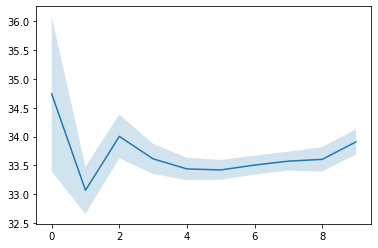

In [25]:
plt.plot(dg)
plt.fill_between(range(len(dg)),np.asarray(dg)-np.asarray(ddg),np.asarray(dg)+np.asarray(ddg),alpha=0.2)

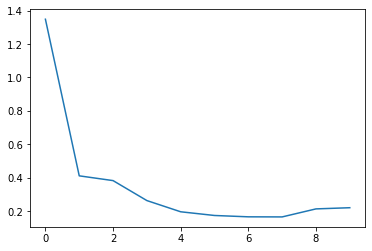

In [26]:
plt.plot(ddg)

## and now for val --> ala

In [27]:
val_ala_hss.extend(500)

DEBUG:mpiplus.mpiplus:Single node: executing <bound method MultiStateSampler._store_options of <instance of HybridRepexSampler>>
DEBUG:openmmtools.multistate.multistatesampler:Storing general ReplicaExchange options...
DEBUG:mpiplus.mpiplus:Running _compute_replica_energies serially.
DEBUG:openmmtools.utils:Computing energy matrix took    0.189s
DEBUG:mpiplus.mpiplus:Single node: executing <bound method MultiStateReporter.write_energies of <openmmtools.multistate.multistatereporter.MultiStateReporter object at 0x7f95978f6390>>
DEBUG:openmmtools.multistate.multistatesampler:********************************************************************************
DEBUG:openmmtools.multistate.multistatesampler:Iteration 1/500
DEBUG:openmmtools.multistate.multistatesampler:********************************************************************************
DEBUG:mpiplus.mpiplus:Single node: executing <function ReplicaExchangeSampler._mix_replicas at 0x7f95a99941e0>
DEBUG:openmmtools.multistate.replicae

In [30]:


ncfile = utils.open_netcdf(f"val_ala.nc")
n_iterations = ncfile.variables['last_iteration'][0]

dg_rev, ddg_rev = [], []
for step in range(1, 101, 10):
    analyzer = MultiStateSamplerAnalyzer(ala_val_reporter,max_n_iterations = step)
    f_ij, df_ij = analyzer.get_free_energy()
    dg_rev.append(f_ij[0,-1])
    ddg_rev.append(df_ij[0,-1])

/home/dominic/anaconda3/envs/openmm/lib/python3.6/site-packages/openmmtools-0.18.3-py3.6-linux-x86_64.egg/openmmtools/multistate/multistateanalyzer.py:1175: UserWarning: Warning: The openmmtools.multistate API is experimental and may change in future releases
  warnings.warn('Warning: The openmmtools.multistate API is experimental and may change in future releases')
DEBUG:openmmtools.multistate.multistateanalyzer:Checking if we need to unbias the restraint...
DEBUG:openmmtools.multistate.multistateanalyzer:Trying to get radially symmetric restraint data...
DEBUG:openmmtools.multistate.multistateanalyzer:Retrieving end thermodynamic states...
DEBUG:openmmtools.multistate.multistateanalyzer:Isolating restraint force...
DEBUG:openmmtools.multistate.multistateanalyzer:No force of type <class 'openmmtools.forces.RadiallySymmetricRestraintForce'> could be found. The restraint will not be unbiased.
DEBUG:openmmtools.multistate.multistateanalyzer:Reading energies...
DEBUG:openmmtools.multistat

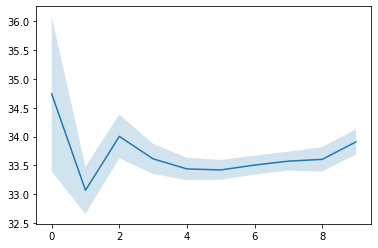

In [31]:
plt.plot(dg_rev)
plt.fill_between(range(len(dg_rev)),np.asarray(dg_rev)-np.asarray(ddg_rev),np.asarray(dg_rev)+np.asarray(ddg_rev),alpha=0.2)